In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np

Using TensorFlow backend.


In [2]:
%load_ext memory_profiler
%load_ext line_profiler
%load_ext timeit

The timeit module is not an IPython extension.


In [3]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Setup

In [5]:
audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Loading

In [10]:
%%file load_blockwise.py

audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

import time
import librosa
import numpy as np
import soundfile as sf

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    h_target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_target.append(sample.h_category)
            target.append(sample.target)
        if debug:
            print("Done")
    if debug:
        print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_target), np.array(target)

def load_file_blockwise(filename, blocksize=1024, overlap=512, debug=False):
    items = []
    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + filename, 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True,
                         fill_value=0.0)
    sr = sf.info(audio_dir + filename).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = librosa.resample(y, sr, SR)
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        
    if debug:
        print("Done")

    return np.array(items)

Overwriting load_blockwise.py


In [11]:
%%time
from load_blockwise import load_audio_blockwise

%memit train_X, train_y, train_yy = load_audio_blockwise(dataset[dataset.fold != 1], orig_blocksize, orig_overlap)

peak memory: 2397.09 MiB, increment: 2092.74 MiB
CPU times: user 4min 56s, sys: 2.05 s, total: 4min 58s
Wall time: 6min 52s


In [12]:
%%time
%memit test_X, test_y, test_yy = load_audio_blockwise(dataset[dataset.fold == 1], orig_blocksize, orig_overlap)

peak memory: 1757.69 MiB, increment: 459.54 MiB
CPU times: user 1min 6s, sys: 432 ms, total: 1min 6s
Wall time: 1min 7s


In [13]:
train_y = np.vstack([train_y, train_yy]).T
test_y = np.vstack([test_y, test_yy]).T

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [14]:
%%file cnnmult.py

import numpy as np
import inspect
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, InputLayer
from kapre.time_frequency import Melspectrogram, Spectrogram

from keras.wrappers.scikit_learn import KerasClassifier

SR=16000

class CNN_Multilayer(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=50, batch_size=128, validation_split=0.05,
                       a_epochs=50, a_batch_size=128,
                       i_epochs=50, i_batch_size=128,
                       verbose=1, threshold=0.75):
        
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        
        for arg, val in values.items():
            setattr(self, arg, val)
            pass
    
    
    def fit(self, X, y):
        
        X = np.array(X)
        y = np.array(y)
        
        dims = X.shape[1]
        t_y = y[:,0]
        a_y = y[:,1][t_y == 0]
        i_y = y[:,1][t_y == 1]
        
        """Top layer of hierarchy"""
        self.clf = KerasClassifier(build_fn=self.deep_net,
                                   feature_count=SR * 5,
                                   epochs=self.epochs, 
                                   batch_size=self.batch_size, 
                                   validation_split=self.validation_split,
                                   verbose=self.verbose
                                  )
        self.clf.fit(X, t_y)
        
        """Animal Layer"""
        self.a_clf = KerasClassifier(build_fn=self.deep_net_a,
                                       feature_count=SR * 5,
                                       epochs=self.a_epochs, 
                                       batch_size=self.a_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        
        self.a_clf.fit(X[t_y == 0], a_y)
        
        """Interacting Materials Layer"""
        self.i_clf = KerasClassifier(build_fn=self.deep_net_i, 
                                       feature_count=SR * 5,
                                       epochs=self.i_epochs, 
                                       batch_size=self.i_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        self.i_clf.fit(X[t_y == 1], i_y)
        
        return self
        
    def predict(self, X, y=None, debug=False):
        predictions=[]
        
        for x in X:
            prob = self.clf.predict_proba(x, verbose=0).squeeze()
            if(debug):
                print(prob)
            if prob[0] > self.threshold:
                pred = self.a_clf.predict(x, verbose=0).squeeze()
            elif prob[1] > self.threshold:
                pred = self.i_clf.predict(x, verbose=0).squeeze()
            else:
                a_pred = self.a_clf.predict(x, verbose=0).squeeze()
                i_pred = self.i_clf.predict(x, verbose=0).squeeze()
                
                a_prob = self.a_clf.predict_proba(x, verbose=0).squeeze() * prob[0]
                i_prob = self.i_clf.predict_proba(x, verbose=0).squeeze() * prob[1]
                
                if(np.max(a_prob) > np.max(i_prob)):
                    pred = a_pred
                else:
                    pred = i_pred
                    
            predictions.append(pred)
        
        return predictions
    
    def predict_proba(self, X, y=None):
        
        prob = self.clf.predict_proba(X, verbose=0).squeeze()

        prob_a = np.multiply(self.a_clf.predict_proba(X, verbose=0).squeeze(),prob[0])

        prob_i = np.multiply(self.i_clf.predict_proba(X, verbose=0).squeeze(),prob[1])
        
        probs = [None] * 50
        for counter, j in enumerate(self.a_clf.classes_):
            probs[j] = prob_a[counter]
        for counter, j in enumerate(self.i_clf.classes_):
            probs[j] = prob_i[counter]
            
        return np.array(probs)
        
    
    def deep_net(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

        # Compile model
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        model.summary()


        return model

    def deep_net_a(self, feature_count):
        # Create Model
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(18, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    def deep_net_i(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

Overwriting cnnmult.py


In [15]:
from cnnmult import CNN_Multilayer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA

clf = CNN_Multilayer(threshold=0.65)

clf.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_1 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                69664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

1520/1520 [==============================] - 43s 28ms/step - loss: 0.0736 - acc: 0.9691 - val_loss: 1.6682 - val_acc: 0.7875
Epoch 48/50
1520/1520 [==============================] - 44s 29ms/step - loss: 0.0914 - acc: 0.9671 - val_loss: 1.0524 - val_acc: 0.8500
Epoch 49/50
1520/1520 [==============================] - 42s 28ms/step - loss: 0.1037 - acc: 0.9572 - val_loss: 1.6195 - val_acc: 0.7625
Epoch 50/50
1520/1520 [==============================] - 47s 31ms/step - loss: 0.0926 - acc: 0.9625 - val_loss: 1.0252 - val_acc: 0.8375
Train on 547 samples, validate on 29 samples
Epoch 1/50
547/547 [==============================] - 15s 28ms/step - loss: 2.8882 - acc: 0.0530 - val_loss: 2.8900 - val_acc: 0.0345
Epoch 2/50
547/547 [==============================] - 15s 27ms/step - loss: 2.8740 - acc: 0.0658 - val_loss: 2.8877 - val_acc: 0.0000e+00
Epoch 3/50
547/547 [==============================] - 16s 29ms/step - loss: 2.8428 - acc: 0.0932 - val_loss: 2.8846 - val_acc: 0.0000e+00
Epoch 4/5

Epoch 7/50
972/972 [==============================] - 27s 28ms/step - loss: 3.2103 - acc: 0.0782 - val_loss: 3.2565 - val_acc: 0.0385
Epoch 8/50
972/972 [==============================] - 28s 29ms/step - loss: 3.1732 - acc: 0.0782 - val_loss: 3.2258 - val_acc: 0.0577
Epoch 9/50
972/972 [==============================] - 28s 29ms/step - loss: 3.1364 - acc: 0.0905 - val_loss: 3.1780 - val_acc: 0.0577
Epoch 10/50
972/972 [==============================] - 27s 28ms/step - loss: 3.0829 - acc: 0.1019 - val_loss: 3.0954 - val_acc: 0.1154
Epoch 11/50
972/972 [==============================] - 29s 30ms/step - loss: 3.0497 - acc: 0.1132 - val_loss: 3.0345 - val_acc: 0.1731
Epoch 12/50
972/972 [==============================] - 27s 28ms/step - loss: 3.0055 - acc: 0.1255 - val_loss: 3.0097 - val_acc: 0.1538
Epoch 13/50
972/972 [==============================] - 28s 29ms/step - loss: 2.9623 - acc: 0.1409 - val_loss: 2.9494 - val_acc: 0.1731
Epoch 14/50
972/972 [==============================] - 31s

CNN_Multilayer(a_batch_size=128, a_epochs=50, batch_size=128, epochs=50,
        i_batch_size=128, i_epochs=50, threshold=0.65,
        validation_split=0.05, verbose=1)

In [16]:
print(test_X[:, np.newaxis, :, :].shape)

(400, 1, 1, 80000)


0.33
Confusion matrix, without normalization
[[3 0 0 ... 0 0 0]
 [0 7 0 ... 0 0 0]
 [1 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [1 0 2 ... 0 0 1]]


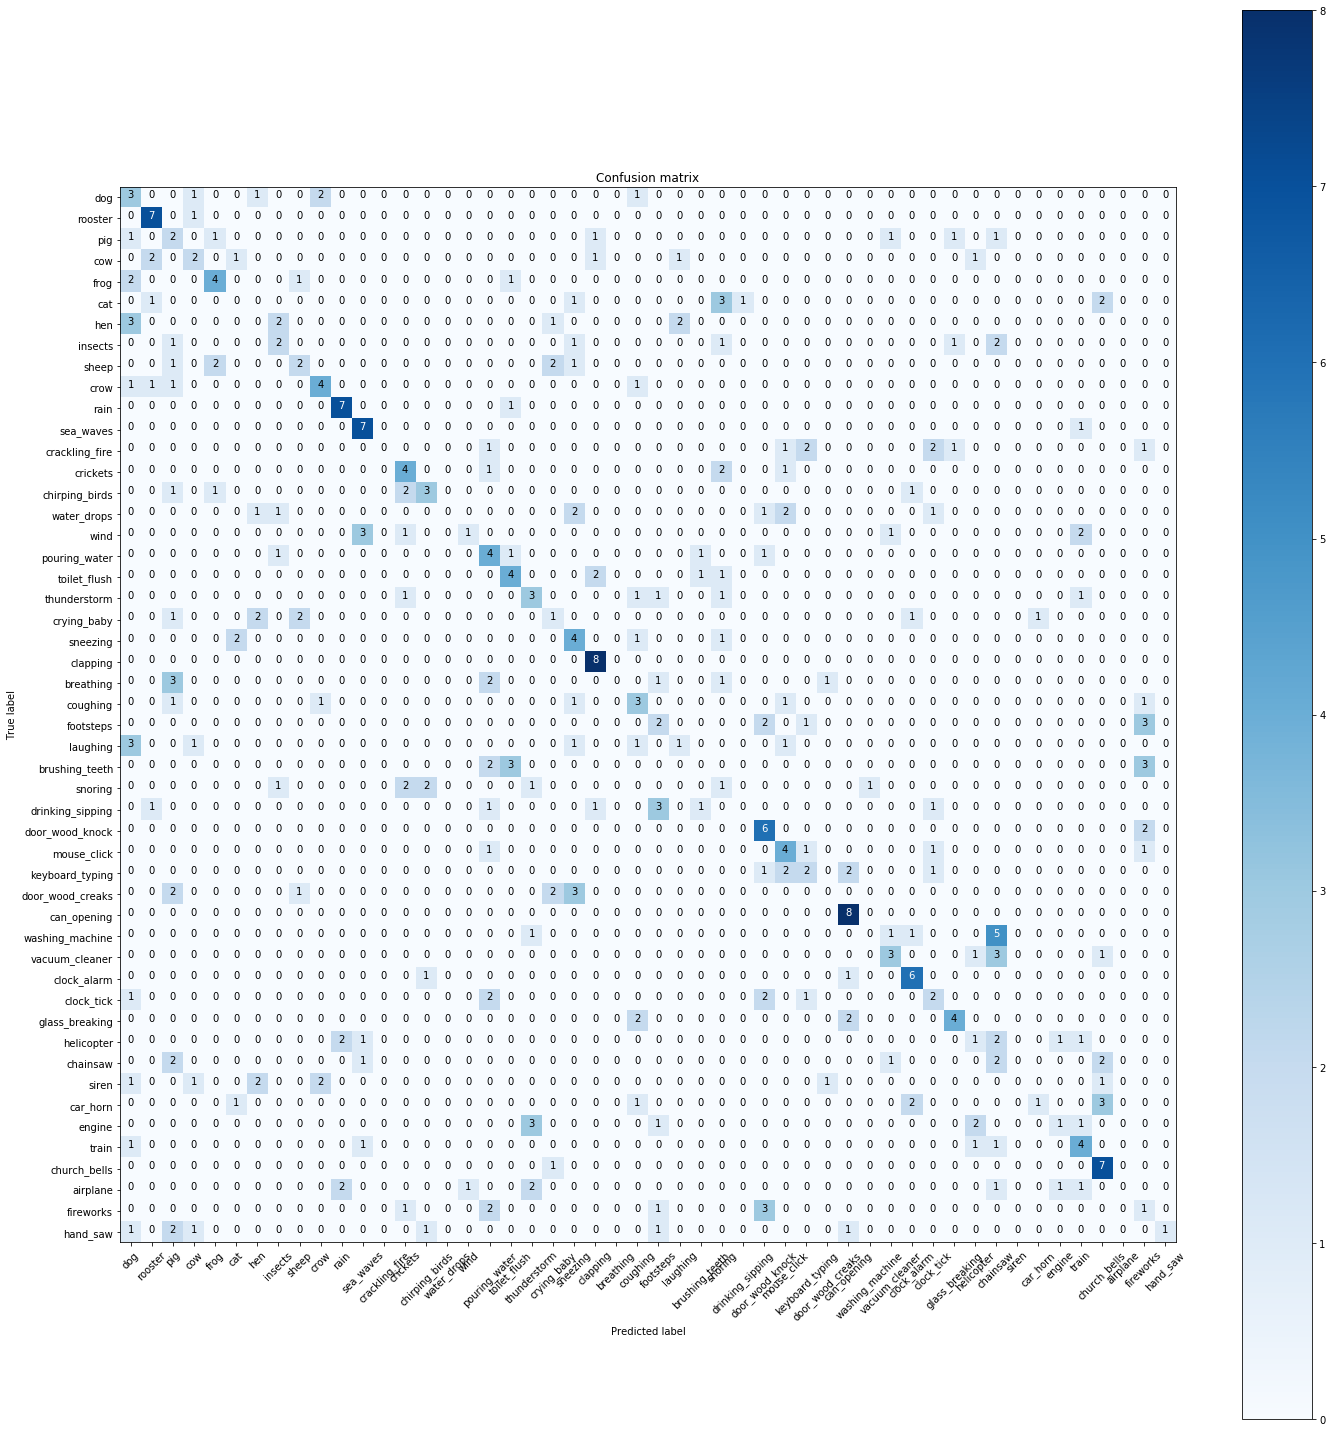

In [17]:
pred = clf.predict(test_X[:, np.newaxis, :, :])
print(metrics.accuracy_score(test_y[:,1], pred))
cm = metrics.confusion_matrix(test_y[:,1], pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [18]:
%%time
import time
from load_blockwise import load_file_blockwise

predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

test = dataset[dataset.fold == 1].reset_index()
    
for data_iloc in range(0,len(test)):
    s_time = time.time()
    x_file = load_file_blockwise(test.iloc[data_iloc].filename,
                                 blocksize=orig_blocksize,
                                 overlap=orig_overlap)
    y_file = test.iloc[data_iloc].target
    
    pred = clf.predict(x_file)
    b = Counter(np.array(pred))
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(y_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))



	File Time: 0.21836066246032715
	File Time: 0.19383716583251953
	File Time: 0.2066514492034912
	File Time: 0.2260301113128662
	File Time: 0.3141469955444336
	File Time: 0.2487173080444336
	File Time: 0.21693968772888184
	File Time: 0.20645880699157715
	File Time: 0.20522809028625488
	File Time: 0.2014625072479248
	File Time: 0.31500768661499023
	File Time: 0.2325444221496582
	File Time: 0.25959038734436035
	File Time: 0.22277021408081055
	File Time: 0.22933149337768555
	File Time: 0.2569451332092285
	File Time: 0.2836599349975586
	File Time: 0.24063682556152344
	File Time: 0.2527344226837158
	File Time: 0.25229382514953613
	File Time: 0.23989653587341309
	File Time: 0.23742103576660156
	File Time: 0.22151994705200195
	File Time: 0.25513720512390137
	File Time: 0.2239396572113037
	File Time: 0.2489452362060547
	File Time: 0.26215195655822754
	File Time: 0.24828338623046875
	File Time: 0.22764086723327637
	File Time: 0.2282717227935791
	File Time: 0.2205052375793457
	File Time: 0.2528538

	File Time: 0.18660283088684082
	File Time: 0.1930217742919922
	File Time: 0.18438053131103516
	File Time: 0.18603730201721191
	File Time: 0.18631577491760254
	File Time: 0.1880943775177002
	File Time: 0.24167776107788086
	File Time: 0.2089700698852539
	File Time: 0.27819085121154785
	File Time: 0.2088165283203125
	File Time: 0.21042943000793457
	File Time: 0.2063591480255127
	File Time: 0.18072795867919922
	File Time: 0.24057602882385254
	File Time: 0.21188783645629883
	File Time: 0.21105432510375977
	File Time: 0.215012788772583
	File Time: 0.18303632736206055
	File Time: 0.19687843322753906
	File Time: 0.18240642547607422
	File Time: 0.24384665489196777
	File Time: 0.23431849479675293
	File Time: 0.218064546585083
	File Time: 0.23782730102539062
	File Time: 0.24779605865478516
	File Time: 0.22261309623718262
	File Time: 0.22436976432800293
	File Time: 0.23076152801513672
	File Time: 0.22504067420959473
	File Time: 0.21535563468933105
	File Time: 0.21363162994384766
	File Time: 0.265

0.33
Confusion matrix, without normalization
[[3 0 0 ... 0 0 0]
 [0 7 0 ... 0 0 0]
 [1 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [1 0 2 ... 0 0 1]]


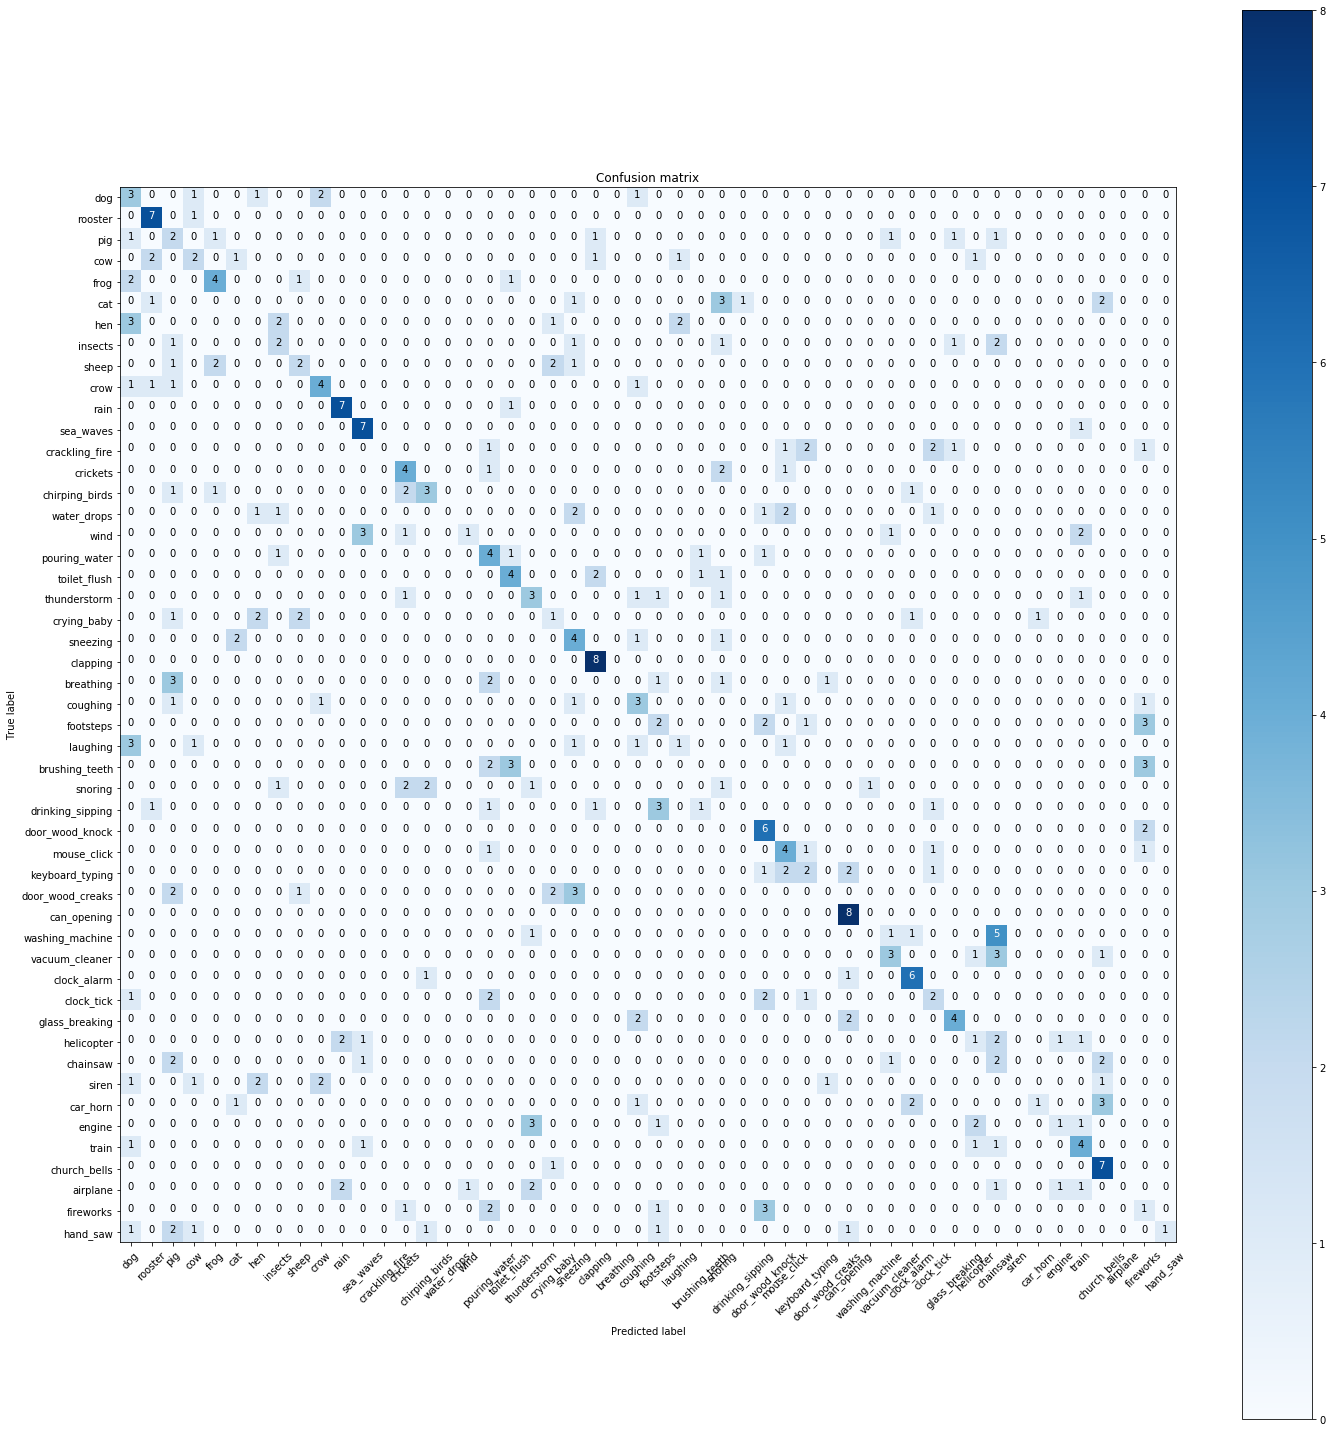

In [19]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [20]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)
    
    predictions = []

    for data_iloc in range(0,len(test)):
        x_file = load_file_blockwise(test.iloc[data_iloc].filename,
                             blocksize=orig_blocksize,
                             overlap=orig_overlap)[0]

        prob = clf.predict_proba(x_file)[l_l]
        pred = clf.predict(x_file[np.newaxis, :, :, :])
        
        predictions.append({
            'file': test.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': prob,
            'prediction': pred
        })
        
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    return predictions

In [21]:
%%time
preds = query_dataset('dog')

CPU times: user 7min 35s, sys: 1min 54s, total: 9min 29s
Wall time: 1min 46s


In [22]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
#     print(misclass)
    return (count - len(misclass))/count

In [23]:
# Checking index
check_accuracy(preds, 'dog', 10)

0.1

In [24]:
accuracies = []
for cls in classes:
    %time preds = query_dataset(cls)
    %time acc = check_accuracy(preds, cls, 10)
    print(cls)
    print(acc)
    print()
    accuracies.append(acc)
    
np.average(accuracies)

CPU times: user 7min 48s, sys: 1min 54s, total: 9min 43s
Wall time: 1min 48s
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 10.8 ms
dog
0.1

CPU times: user 7min 32s, sys: 2min 21s, total: 9min 54s
Wall time: 1min 49s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.38 ms
rooster
0.5

CPU times: user 7min 38s, sys: 1min 58s, total: 9min 37s
Wall time: 1min 50s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 10.7 ms
pig
0.2

CPU times: user 7min 40s, sys: 2min 3s, total: 9min 43s
Wall time: 1min 54s
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.5 ms
cow
0.2

CPU times: user 7min 35s, sys: 2min 3s, total: 9min 38s
Wall time: 1min 49s
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 10.1 ms
frog
0.5

CPU times: user 7min 42s, sys: 1min 55s, total: 9min 37s
Wall time: 1min 50s
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.8 ms
cat
0.1

CPU times: user 7min 43s, sys: 1min 54s, total: 9min 37s
Wall time: 1min 48s
CPU times: use

0.294

In [26]:
clf.__threshold = 0.75
accuracies = []
for cls in classes:
    %time preds = query_dataset(cls)
    %time acc = check_accuracy(preds, cls, 10)
    print(cls)
    print(acc)
    print()
    accuracies.append(acc)
    
np.average(accuracies)

CPU times: user 7min 44s, sys: 1min 52s, total: 9min 36s
Wall time: 2min
CPU times: user 20 ms, sys: 24 ms, total: 44 ms
Wall time: 67.5 ms
dog
0.1

CPU times: user 7min 38s, sys: 2min 13s, total: 9min 52s
Wall time: 2min 19s
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 9.06 ms
rooster
0.5

CPU times: user 7min 33s, sys: 2min 20s, total: 9min 54s
Wall time: 2min 40s
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.1 ms
pig
0.2

CPU times: user 7min 16s, sys: 2min 19s, total: 9min 36s
Wall time: 2min 15s
CPU times: user 24 ms, sys: 208 ms, total: 232 ms
Wall time: 12.2 ms
cow
0.2

CPU times: user 7min 29s, sys: 1min 51s, total: 9min 21s
Wall time: 2min 6s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.6 ms
frog
0.5

CPU times: user 7min 29s, sys: 2min 58s, total: 10min 27s
Wall time: 2min 42s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.11 ms
cat
0.1

CPU times: user 7min 18s, sys: 2min 34s, total: 9min 52s
Wall time: 2min 40s
CPU times: us

0.294

In [27]:
clf.__threshold = 0.5
accuracies = []
for cls in classes:
    %time preds = query_dataset(cls)
    %time acc = check_accuracy(preds, cls, 10)
    print(cls)
    print(acc)
    print()
    accuracies.append(acc)
    
np.average(accuracies)

CPU times: user 7min 2s, sys: 3min 4s, total: 10min 6s
Wall time: 2min 12s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.37 ms
dog
0.1

CPU times: user 6min 59s, sys: 3min 8s, total: 10min 7s
Wall time: 2min 48s
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 9.21 ms
rooster
0.5

CPU times: user 7min 2s, sys: 3min 4s, total: 10min 6s
Wall time: 2min 54s
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.3 ms
pig
0.2

CPU times: user 6min 56s, sys: 3min 20s, total: 10min 16s
Wall time: 2min 32s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.81 ms
cow
0.2

CPU times: user 6min 54s, sys: 2min 57s, total: 9min 52s
Wall time: 3min 20s
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.73 ms
frog
0.5

CPU times: user 6min 50s, sys: 3min 20s, total: 10min 11s
Wall time: 2min 30s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 10.2 ms
cat
0.1

CPU times: user 7min 3s, sys: 3min 20s, total: 10min 23s
Wall time: 4min 6s
CPU times: user 12 

0.294